In [15]:
import pandas as pd
import yfinance as yf 
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans

In [16]:
# Manual inputs
TIMEFRAME = "1d"
LOOKBACK_PERIOD = "5y"

# Preprocessing:

In [73]:
# Get the list of S&P500 stocks from Wikipedia
URL = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp500 = pd.read_html(URL)
tickers = sp500[0]['Symbol'].to_list()
print(tickers)

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BK', 'BBWI', 'BAX', 'BDX', 'BRK.B', 'BBY', 'BIO', 'TECH', 'BIIB', 'BLK', 'BX', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF.B', 'BLDR', 'BG', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'COR', 'CNC', 'CNP', 'CDAY', 'CF', 'CHRW', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CCI', 'CSX', 'CMI', 'C

In [86]:
tickers = ['SPY'] + tickers # Add SPY to the list of tickers, will be used as a benchmark

In [87]:
stock_returns = [] # List of series

for stock in tickers:
  data = yf.Ticker(stock).history(period=LOOKBACK_PERIOD, interval=TIMEFRAME)
  data["returns"] =  np.log(1+data["Close"].pct_change())
  data.rename(columns={"returns": stock}, inplace=True)
  if len(data) > 0:
    stock_returns.append(data[stock])


ERROR BRK.B: No data found, symbol may be delisted
ERROR BF.B: No price data found, symbol may be delisted (period=5y)


In [88]:
short_listed_stocks = []

# Filter 1: Must be in uptrend
for e in stock_returns:
    lookback = 200 # from tail of series e
    drift = e[-lookback:].mean() - 0.5 * e[-lookback:].var()
    print(e.name, drift)
    if drift > 0:
        short_listed_stocks.append(e.name)
        # print("Short listed: ", e.name)
    else:
        print("\t(X) Not short listed: ", e.name)

SPY 0.0009306720557134325
MMM 0.00036024196967097635
AOS 0.0009123321112087632
ABT 0.0005179570740142703
ABBV 0.00021429789191514795
ACN 0.0015537990883730717
ADBE 0.0022939501576373267
AMD 0.0014086736466732512
AES -0.0010398882383490268
	(X) Not short listed:  AES
AFL 0.0014565339256418434
A -3.402838638701255e-05
	(X) Not short listed:  A
APD -0.00011343831555689818
	(X) Not short listed:  APD
ABNB 0.0002781124395466509
AKAM 0.002300725614214715
ALB -0.00230377456878371
	(X) Not short listed:  ALB
ARE 0.00018676892701183166
ALGN -0.0015173858866979668
	(X) Not short listed:  ALGN
ALLE 0.00070648171512107
LNT -0.00010041404617725968
	(X) Not short listed:  LNT
ALL 0.0012197303975564385
GOOGL 0.0014529370574798903
GOOG 0.0014639879006967083
MO -0.00014460735510029533
	(X) Not short listed:  MO
AMZN 0.0018383671353629212
AMCR -0.00040917388724277424
	(X) Not short listed:  AMCR
AEE -0.0007361891302325716
	(X) Not short listed:  AEE
AAL -0.0004674654032254434
	(X) Not short listed:  AAL

### Correlation matrix

In [89]:
correl_matrix = pd.DataFrame(stock_returns).T.corr().round(4)

In [90]:
SHOW_MATRIX = False
_matrix = correl_matrix.style.background_gradient(cmap ='coolwarm')
if not SHOW_MATRIX:
  _matrix = None
_matrix

### Analysis: Market beta vs Market correlation

In [91]:
# Get data for the stock and SPY
stock = yf.Ticker("AAPL")
SPY = yf.Ticker("SPY")

def calc_beta(stock, benchmark="SPY"): 

    # Get the historical closes
    stock_hc = yf.Ticker(stock).history(period=LOOKBACK_PERIOD)
    benchmark_hc = yf.Ticker(benchmark).history(period=LOOKBACK_PERIOD)

    # Calculate the daily returns for the stock and SPY
    stock_returns = stock_hc['Close'].pct_change()
    SPY_returns = benchmark_hc['Close'].pct_change()

    # Calculate the beta of the stock against SPY
    covar = stock_returns.cov(SPY_returns)
    var = SPY_returns.var()

    return covar / var # beta

In [ ]:
# Calc the beta in each of the stock in short_listed_stocks
beta_map = {}
for stock in short_listed_stocks:
    beta_map[stock] = calc_beta(stock)

In [96]:
# Calc the correlation of each stock with SPY
correl_with_SPY_map = {}
for stock in short_listed_stocks:
    correl_with_SPY_map[stock] = correl_matrix[stock]["SPY"]

# Classical Machine Learning:

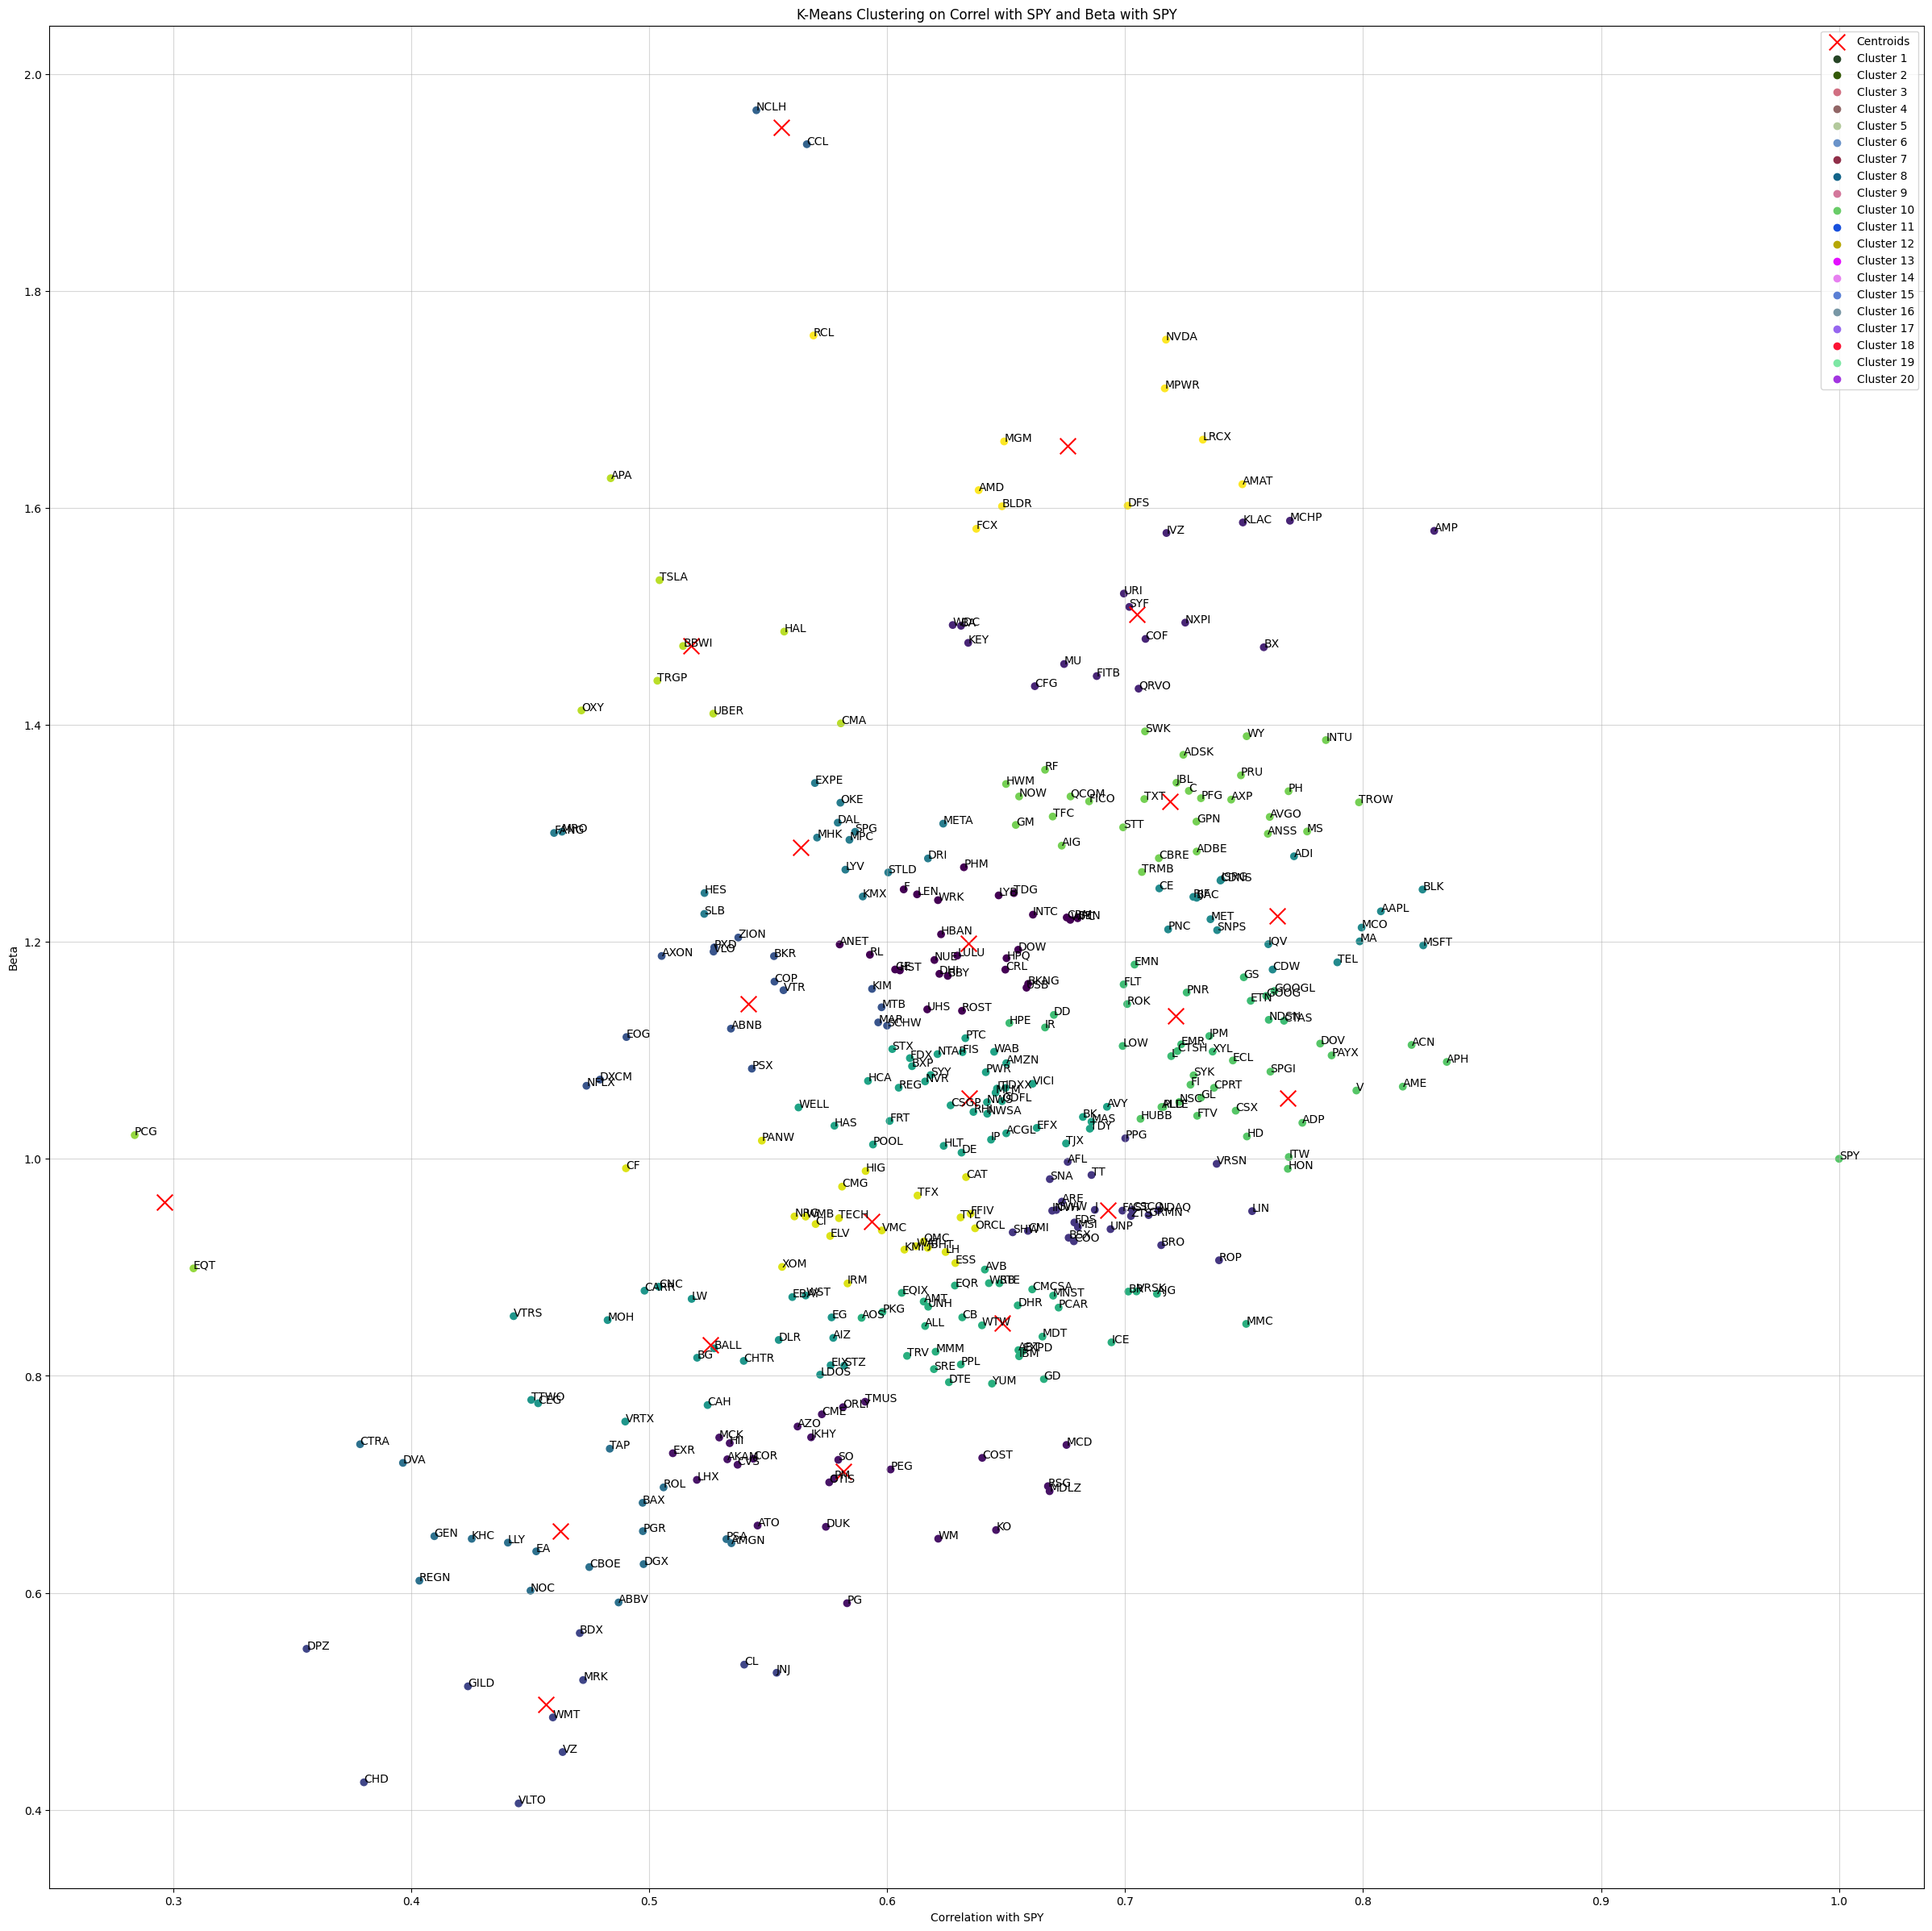

In [98]:
N_CLUSTERS = 20

# Features
X = pd.DataFrame(list(zip(correl_with_SPY_map.values(), beta_map.values())), columns=["Correl", "Beta"])

# Create a K-Means model with N_CLUSTERS clusters
kmeans = KMeans(n_clusters=N_CLUSTERS)

# Fit the model to the data
kmeans.fit(X)

# Predict the clusters
clusters = kmeans.predict(X)

# Add the clusters to the dataframe
X["Cluster"] = clusters

# Plot the clusters
plt.figure(figsize=(30, 30))
plt.scatter(X["Correl"], X["Beta"], c=X["Cluster"], cmap="viridis")
plt.xlabel("Correlation with SPY"), plt.ylabel("Beta")
plt.title("K-Means Clustering on Correl with SPY and Beta with SPY")
plt.grid(alpha=0.5)

# Add labels to each point
for label, correl in correl_with_SPY_map.items():
    beta = beta_map[label]
    plt.annotate(label, (correl, beta))

# Add the centroids to the plot
centroids = kmeans.cluster_centers_ 
plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=200, c="red")

# Legend
plt.scatter([], [], marker="x", s=200, color="red", label="Centroids")
_colors = ["#"+''.join([np.random.choice(list('0123456789ABCDEF')) for j in range(6)]) for i in range(N_CLUSTERS)]
for i in range(N_CLUSTERS):
    plt.scatter([], [], color=_colors[i], label="Cluster "+str(i+1))
plt.legend();

plt.show()

In [108]:
# Dataframe with rows: stock name, cluster number
cluster_map = pd.DataFrame()
cluster_map['data_index'] = X.index.values
cluster_map['cluster'] = kmeans.labels_
cluster_map['Ticker'] = list(correl_with_SPY_map.keys())

In [111]:
def clean_data(cluster_map):
    # Sort by column: 'cluster' (ascending)
    cluster_map = cluster_map.sort_values(['cluster'])
    return cluster_map

cluster_map_clean = clean_data(cluster_map.copy())
cluster_map_clean.head()

,data_index,cluster,Ticker
301,301,0,CRM
114,114,0,DHI
356,356,0,WFC
211,211,0,LULU
334,334,0,USB
